## Array Response Function depending on Array Configuration & Frequency

This notebook intends to introduce the response function of an array of seismometers. Different array configurations are compared in terms of their array response function. The dimensions of the array and the frequencies or rather wave numbers can be adjusted.

### Importing Libraries

Required python libraries or single methods are being loaded. 
If some library is not found you probably have to isntall it using: conda install 'Lib_Name' or pip install 'Lib_Name' 

In [192]:

import numpy as np
import matplotlib.pyplot as plt

from obspy.clients.fdsn import Client 
from obspy import UTCDateTime
from obspy.imaging.cm import obspy_sequential
from obspy.signal.array_analysis import array_transff_wavenumber
from mpl_toolkits.basemap import Basemap


### Setting Variables

In [193]:
## set input path
ipath = "/home/andbro/notebooks/backprojections/data"

## set limits for wavenumber differences to analyze, corresponding to frequency variations
klim = 40.
dx = 50.

kxmin = -klim
kxmax = klim
kymin = -klim
kymax = klim
kstep = klim / dx

### Defining Methods

'__makeplot_array' defines the plot of an array and its array response function next to it. 

In [194]:

def __makeplot_array1(array, transff, unit="km"):
    
    ## calulcate geometrical center of array
    array_center = [np.median(array[:,0]), np.median(array[:,1])]
    
    ## find geometrical limits of array
    lon_min, lon_max = np.min(array[:,0]), np.max(array[:,0])
    lat_min, lat_max = np.min(array[:,1]), np.max(array[:,1])
    
    
    fig, axes = plt.subplots(1,2, figsize=(16,6))

    fs=12
    
    if unit is "km":
        xdata = (array[:,0]-array_center[0])*111
        ydata = (array[:,1]-array_center[1])*111 * np.cos(array[:,1]/180*np.pi)
        x0, y0 = 0.0, 0.0
    elif unit is "deg":
        xdata = array[:,0]
        ydata = array[:,1]
        x0, y0 = array_center[0], array_center[1]
        
    ## ________________________________________________
    axes[0].plot(xdata, ydata,'kv')
    axes[0].scatter(x0, y0, color='red', marker='o', s=15)
    
    if unit is "km":
        axes[0].set_xlabel('X (km)', fontsize=fs)
        axes[0].set_ylabel('Y (km)', fontsize=fs)

        axes[0].set_ylim([-max(abs(ydata)), max(abs(ydata))])
        axes[0].set_ylim([-max(abs(ydata)), max(abs(ydata))])
                 
    elif unit is "deg":
        axes[0].set_xlabel('Longitude (°)', fontsize=fs)
        axes[0].set_ylabel('Latitude (°)', fontsize=fs)
                 
    axes[0].set_title('Square Array configuration', fontsize=fs+2)

    
    ## ________________________________________________
    ax2 = axes[1].pcolor(np.arange(kxmin, kxmax + kstep * 1.1, kstep) - kstep / 2.,
               np.arange(kymin, kymax + kstep * 1.1, kstep) - kstep / 2.,
               transff.T, cmap=obspy_sequential)
    
    plt.colorbar(ax2, ax=axes[:])
    ax2.set_clim(0., 1.)
    
    axes[1].set_xlim(kxmin, kxmax)
    axes[1].set_ylim(kymin, kymax)
    axes[1].set_xlabel('wave number (m$^{-1}$)', fontsize=fs)
    axes[1].set_ylabel('wave number (m$^{-1}$)', fontsize=fs)
    axes[1].set_title('ARF Square Array', fontsize=fs+2)
    
    plt.show()    


In [195]:

def __makeplot_array2(array, transff):
    
    array_center = [np.median(array[:,0]), np.median(array[:,1])]
    
    fig, axes = plt.subplots(1,2, figsize=(16,6))

    fs=12
    zoom_scale=0.001
    
    
    ## ________________________________________________
     
    axes[0].set_title("Array Geometry", fontsize=fs+2)

    bbox = [np.min(array[1])-zoom_scale,
            np.max(array[1])+zoom_scale,
            np.min(array[0])-zoom_scale,
            np.max(array[0])+zoom_scale]

    print(bbox[0], bbox[2], bbox[1], bbox[3])
    ## create a basemap to plot onto
    m = Basemap(projection='merc',
                llcrnrlat=bbox[0],
                urcrnrlat=bbox[1],
                llcrnrlon=bbox[2],
                urcrnrlon=bbox[3],
                resolution='i',                
                lat_ts=10,
                ax=axes[0],
               )

    ## configure latitude and longitude lines and labels
    m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),
                    labels=[1,0,0,0], 
                    fmt="%3.1f",
                   )
    m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),
                    labels=[0,0,0,1], 
                    rotation=+45, 
                    fmt="%3.1f",
                   )

    # m.drawcoastlines()
    # m.fillcontinents(color='lightgrey',lake_color='dodgerblue')

    ## project lat/lon to map coordinates
    x,y = m(array[0],array[1])

    m.plot(x,y,
           'kv',
           markersize=15,
          )

#     plt.xlabel('Longitude', fontsize=fs)
#     plt.ylabel('Latitude', fontsize=fs)  


    ## ________________________________________________
    ax2 = axes[1].pcolor(np.arange(kxmin, kxmax + kstep * 1.1, kstep) - kstep / 2.,
               np.arange(kymin, kymax + kstep * 1.1, kstep) - kstep / 2.,
               transff.T, cmap=obspy_sequential)
    
    plt.colorbar(ax2, ax=axes[:])
    ax2.set_clim(0., 1.)
    
    axes[1].set_xlim(kxmin, kxmax)
    axes[1].set_ylim(kymin, kymax)
    axes[1].set_xlabel('wave number (m$^{-1}$)', fontsize=fs)
    axes[1].set_ylabel('wave number (m$^{-1}$)', fontsize=fs)
    axes[1].set_title('ARF Square Array', fontsize=fs+2)
    
    plt.show()    
    

'__get_array_stations': stations specified within the 'seed_id' are querried. tbeg and 'tend' are start and end time, respectively 

In [196]:

def __get_array_stations(seed_id, tbeg, tend):

    ## split up the seed ID code
    net, sta, loc, cha  = seed_id.split(".")

    ## obtain the inventory information
    inv_check = c.get_stations(network=net, 
                               station=sta,
                               channel=cha,
                               starttime=tbeg,
                               endtime=tend
                              )
    #inv_check.plot() 
    inv_check.plot(projection="local");
    
    codes, lon, lat, elev = [], [], [], []
    
    for network in inv_check:
        for i, station in enumerate(network):

            codes.append(station.code)
            lon.append(station.longitude)
            lat.append(station.latitude)
            elev.append(station.elevation)

    
    return codes, np.array([lon, lat, elev])


### Plotting Array Geometry and Response Function

First test it for an array previously downloaded in a square shape. Then compare it to an cross-shaped array configuration.

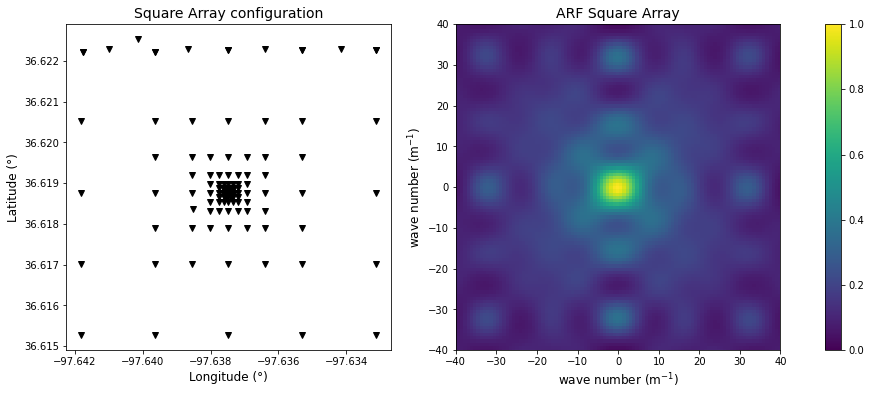

In [197]:
## load the Oklahoma array to monitor induced seismicity
array_ok = np.loadtxt(f"{ipath}/array_ok.txt")


## compute transfer function as a function of wavenumber difference
transff = array_transff_wavenumber(array_ok, 
                                   klim, 
                                   kstep, 
                                   coordsys='lonlat'
                                  )

## call the plotting method  
__makeplot_array1(array_ok, transff, unit="deg")

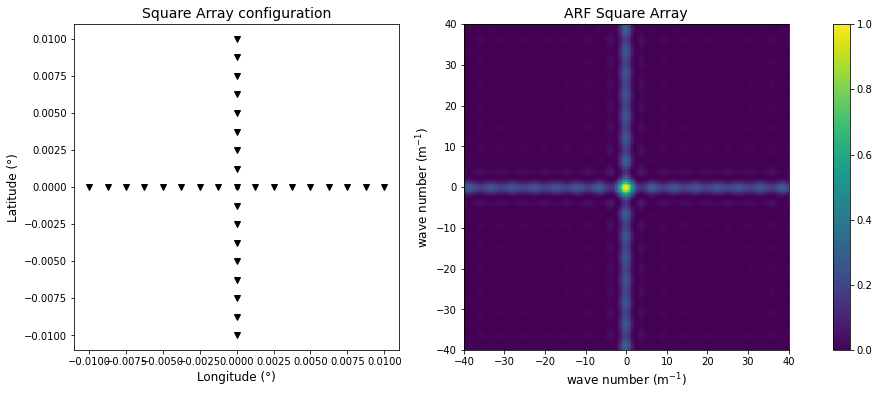

In [224]:
## cross linear array
array_linear_cross = np.loadtxt(f"{ipath}/array_linear_cross.txt")

## change the size of the array, units in km
array_linear_cross /= 2e4 # --> test 2e3 and 2e5 


## compute transfer function as a function of wavenumber difference
transff = array_transff_wavenumber(array_linear_cross, 
                                   klim, 
                                   kstep, 
                                   coordsys='lonlat'
                                  )

## call the plotting method
__makeplot_array1(array_linear_cross, transff, unit="deg")

### Obtain station information online

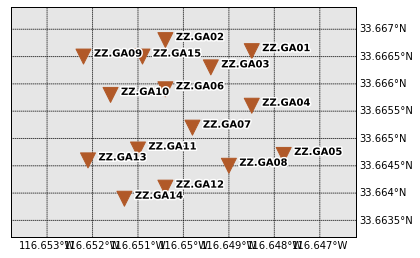

In [199]:
## define an client for the fdsn request
c = Client("IRIS")

## specify start and end times
tbeg = UTCDateTime("2011-06-06T12:16:00.000")
tend = UTCDateTime("2011-06-06T12:18:00.000")


## call the method to obtain stations information
array_stations, array_coords = __get_array_stations("ZZ.GA*..SHZ", tbeg, tend)


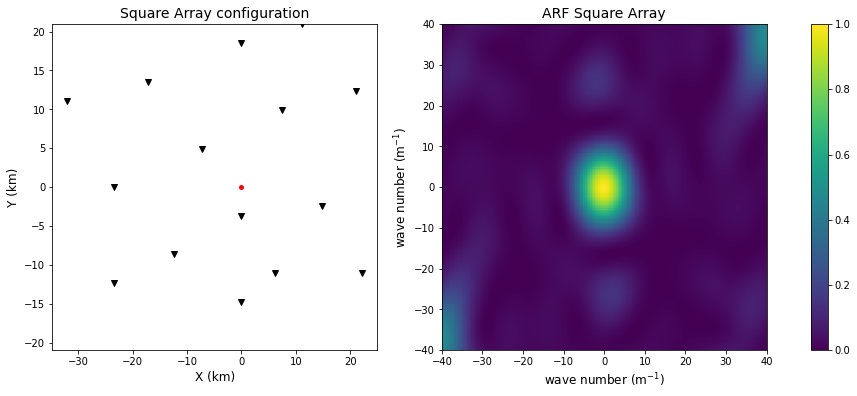

In [221]:
## define wave number limit
klim = 40.
kstep = klim / 100.


##convert elevation from m to km
array_coords[2][:] = array_coords[2][:]/1000 

lon_center, lat_center = np.median(array_coords[0]), np.median(array_coords[1])
x,y = [],[]

for lat, lon in zip(array_coords[1], array_coords[0]):
    x.append((lon_center-lon)*111)
    y.append((lat_center-lat)*111)

xyz = np.column_stack(([x, y, array_coords[2]]))



# compute transfer function as a function of wavenumber difference
transff = array_transff_wavenumber(xyz, klim, kstep, coordsys='xy')


## call plotting method
__makeplot_array1(xyz, transff, unit="km")

#__makeplot_array2(array_coords, transff)
